# 01 · Cuantización y Optimización de Inferencia

❤️ Creado por [@Edison_Bejarano](https://github.com/EjbejaranosAI/llm-hub/blob/main/mastery/notebooks/).

**Objetivo:** cuantizar un modelo (ej. LLaMA/Mistral) y comparar memoria/latencia antes y después.

**Prerequisitos:** Python 3.11+, GPU opcional, drivers/CUDA si aplica.

**Índice:**
1. Ejemplo modelo simple
2. Comparativa de carga de modelo
  - Cuantización (bitsandbytes / AutoGPTQ)
  - Métricas (memoria Vram/latencia) TTFT, TPS
5. Conclusiones

# 1. Ejemplo de cuantización simple



## 1.1 Ejemplo en modelo simple

Vamos a cargar un modelo normal con la librería de Torch y realizamos una simple cuantización.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Load a sample dataset: MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 636kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


In [2]:
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1):  # one epoch for simplicity
    model.train()
    for images, labels in train_loader:
        images = images.view(-1, 28*28)  # flatten the images
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [3]:
model.eval()  # Set the model to inference mode
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

/tmp/ipython-input-361731121.py:2: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


In [4]:
def evaluate_model(model, data_loader):
    """
    Evalúa la accuracy (porcentaje de aciertos) de 'model' sobre 'data_loader'.
    Supone un clasificador con logits por clase en la salida.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28*28)  # flatten the images
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

accuracy_original = evaluate_model(model, train_loader)
accuracy_quantized = evaluate_model(quantized_model, train_loader)

print(f'Accuracy del modelo original: {accuracy_original:.2f}%')
print(f'Accuracy del modelo cuantizado: {accuracy_quantized:.2f}%')

Accuracy of original model: 93.63833333333334%
Accuracy of quantized model: 93.63%


In [5]:
import numpy as np

def quantile_quantization(data, num_bins):
    """
    'Cuantización por cuantiles' (NO uniforme):
    - Los cuantiles son los “bordes” de cada bin y hay que guardarlos si luego quisieras “descuantizar” aproximando al centro de cada bin.
    - Divide la distribución en 'num_bins' segmentos con ~igual número de muestras.
    - No es lo que hacen PyTorch/TFLite por defecto en redes: allí se usa cuantización uniforme affine con escala s y zero-point z (per-tensor/per-canal) porque es amigable con kernels y hardware (INT8).
    - Cada valor se asigna al índice del segmento (0..num_bins-1).
    - Es una cuantización NO uniforme (los “pasos” varían según la densidad de datos).
    - OJO: esto NO es la cuantización affine típica (scale + zero-point) usada en NN.
    """
    # Puntos de corte (cuantiles) desde 0% hasta 100%.
    # Tendrás num_bins+1 cuantiles (incluye extremos).
    quantiles = np.quantile(data, np.linspace(0, 1, num_bins+1))
    quantized_data = np.digitize(data, quantiles) - 1  # Adjust indices to be from 0 to num_bins-1
    return quantized_data, quantiles

# Example data and quantization
data = np.random.randn(1000)  # Normally distributed data
num_bins = 10  # Number of bins
quantized_data, quantiles = quantile_quantization(data, num_bins)

print("Datos cuantizados (primeros 10):", quantized_data[:10])
print("Puntos de corte (cuantiles):", quantiles)

Quantized data: [1 4 1 5 8 1 7 7 5 6]
Quantiles: [-3.00646204e+00 -1.31891121e+00 -8.95405657e-01 -5.55652582e-01
 -2.47088213e-01  2.76932840e-03  2.58299958e-01  5.64046419e-01
  9.01438812e-01  1.32423139e+00  2.83611649e+00]


## 2. Ejemplo en un modelo de Lenguaje pequeño (Bert)

### Quantize_dynamic (PyTorch) — ¿qué es y cuándo usarlo?

- Qué hace: convierte un modelo float a cuantización dinámica: sólo los pesos pasan a INT8 (u otro dtype), y las activaciones se cuantizan “al vuelo” durante la inferencia. PyTorch reemplaza automáticamente módulos como nn.Linear y LSTM por sus versiones dinámicas y te devuelve un modelo CPU-friendly (es decir, orientado a CPU). No requiere fine-tuning ni dataset de calibración.


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.quantization import quantize_dynamic

# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
# Example input text
text = "Hello, this is an example to test BERT model performance."

# Encode text
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

# Perform inference before quantization
with torch.no_grad():
    original_output = model(**inputs)

# Apply dynamic quantization
quantized_model = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)


# Perform inference with quantized model
with torch.no_grad():
    quantized_output = quantized_model(**inputs)

# Compare the outputs (optional, for demonstration)
print("Original output:", original_output.logits)
print("Quantized output:", quantized_output.logits)

# Save the quantized model using PyTorch
torch.save(quantized_model.state_dict(), "./quantized_bert_model.pth")

/tmp/ipython-input-3406444458.py:12: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)


Original output: tensor([[ 0.2567, -0.5152]])
Quantized output: tensor([[ 0.3300, -0.3958]])


In [9]:
# Load the quantized model
model_loaded = BertForSequenceClassification.from_pretrained(model_name)  # Load the original configuration
model_loaded = quantize_dynamic(model_loaded, {torch.nn.Linear}, dtype=torch.qint8)  # Re-apply quantization
model_loaded.load_state_dict(torch.load("./quantized_bert_model.pth"))

# Perform inference with the loaded quantized model
model_loaded.eval()
with torch.no_grad():
    output_loaded = model_loaded(**inputs)

print("Output from loaded quantized model:", output_loaded.logits)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-175580447.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
 

Output from loaded quantized model: tensor([[ 0.3300, -0.3958]])


# 2. 📘 Benchmark de cuantización en LLMs
## Objetivo: comparar FP16, 8-bit y 4-bit en VRAM, latencia y tokens/segundo


### Setup de librerías

In [1]:
!pip install -q -U bitsandbytes
!pip install -U -q transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 144.4 MB/s eta 0:00:00


In [2]:
# =======================
# 1. Librerías necesarias
# =======================
import time, torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Configuración global de gráficos
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)



### Utils functions

El TTFT mide cuánto tarda el modelo en producir el primer token desde que recibe el prompt.
Se mide separando el tiempo de model.generate() en:

TTFT: tiempo hasta que aparece el primer token generado.

TPS: tokens/segundo después del primero.

En transformers, no tenemos un "callback" nativo para capturar token por token, pero podemos hacer un truco:

1. Ejecutar generate(max_new_tokens=1) para medir solo TTFT.

2. Luego medir generate(max_new_tokens=N) para throughput normal.

In [21]:
import torch, time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Utilidad para VRAM
# ================================
def gpu_peak_gb():
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / (1024**3)
    return float("nan")

# ================================
# Benchmark function
# ================================
def gen_and_bench(model, tok, prompt, max_new=64, runs=5):
    """
    Devuelve:
      - Tiempo promedio de generación completa (s)
      - TTFT (s) = tiempo al primer token
      - TPS (tokens/segundo)
      - VRAM pico (GB)
    """
    device = next(model.parameters()).device
    inputs = tok(prompt, return_tensors="pt").to(device)

    # 🔄 Warmup
    with torch.inference_mode():
        _ = model.generate(**inputs, max_new_tokens=8)

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    total_gen_tokens = 0
    total_ttft = 0.0
    total_time = 0.0

    with torch.inference_mode():
        for _ in range(runs):
            # 🕒 medir TTFT con 1 token
            t0 = time.perf_counter()
            _ = model.generate(**inputs, max_new_tokens=1)
            t1 = time.perf_counter()
            total_ttft += (t1 - t0)

            # 🕒 medir generación normal
            t0 = time.perf_counter()
            out = model.generate(**inputs, max_new_tokens=max_new)
            t1 = time.perf_counter()

            seq_len = out.shape[-1]
            prompt_len = inputs["input_ids"].shape[-1]
            total_gen_tokens += max(seq_len - prompt_len, 0)
            total_time += (t1 - t0)

    sec = total_time / runs
    ttft = total_ttft / runs
    tps = (total_gen_tokens / runs) / sec if sec > 0 else float("nan")
    peak = gpu_peak_gb()

    return sec, ttft, tps, peak


## Cargando modelos cuantizados con BitsAndBytes

In [22]:
# =======================================
# 📦 Imports
# =======================================
import torch, time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig


# =======================================
# ⚙️ Configuración
# =======================================
MODEL  = "ModelCloud/Llama3.2-1B-Instruct"   # modelo de ejemplo
PROMPT = "Explica en dos frases qué es la cuantización affine."
MAX_NEW_TOKENS = 64
RUNS = 10

# Tokenizer
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=True)



In [23]:
# =======================================
# 🚀 Cargar Modelos
# =======================================

results = []

# ========================
# 4. Benchmark FP16 (base)
# ========================
print("Cargando modelo FP16...")
try:
    model_fp16 = AutoModelForCausalLM.from_pretrained(
        MODEL, torch_dtype="auto", device_map="auto"
    )
    sec, ttft, tps, gb = gen_and_bench(model_fp16, tok, PROMPT, MAX_NEW_TOKENS, RUNS)
    results.append({"config":"FP16 (baseline)","sec/gen":sec,"TTFT (s)":ttft,"tok/s":tps,"peak_VRAM_GB":gb})
    del model_fp16; torch.cuda.empty_cache()
except Exception as e:
    print("⚠️ No se pudo cargar FP16 baseline:", e)



Cargando modelo FP16...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [24]:
# ========================
# 5. Benchmark 8-bit (LLM)
# ========================
print("Cargando modelo 8-bit...")
bnb_8 = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False
)
model_int8 = AutoModelForCausalLM.from_pretrained(
    MODEL, quantization_config=bnb_8, device_map="auto"
)
sec, ttft, tps, gb = gen_and_bench(model_int8, tok, PROMPT, MAX_NEW_TOKENS, RUNS)
results.append({"config":"bnb 8-bit (LLM.int8)","sec/gen":sec,"TTFT (s)":ttft,"tok/s":tps,"peak_VRAM_GB":gb})
del model_int8; torch.cuda.empty_cache()




Cargando modelo 8-bit...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [25]:
# ========================
# 6. Benchmark 4-bit (NF4)
# ========================
print("Cargando modelo 4-bit...")
bnb_4 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=(torch.bfloat16
                            if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
                            else torch.float16)
)
model_nf4 = AutoModelForCausalLM.from_pretrained(
    MODEL, quantization_config=bnb_4, device_map="auto"
)
sec, ttft, tps, gb = gen_and_bench(model_nf4, tok, PROMPT, MAX_NEW_TOKENS, RUNS)
results.append({"config":"bnb 4-bit (NF4)","sec/gen":sec,"TTFT (s)":ttft,"tok/s":tps,"peak_VRAM_GB":gb})
del model_nf4; torch.cuda.empty_cache()





Cargando modelo 4-bit...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

## Benchmarking

In [26]:
results

[{'config': 'FP16 (baseline)',
  'sec/gen': 1.4453591808000283,
  'TTFT (s)': 0.07650837120002052,
  'tok/s': 44.279650933946414,
  'peak_VRAM_GB': 2.7872838973999023},
 {'config': 'bnb 8-bit (LLM.int8)',
  'sec/gen': 4.9977621499999945,
  'TTFT (s)': 0.13165159909999602,
  'tok/s': 12.805731461230117,
  'peak_VRAM_GB': 1.8814687728881836},
 {'config': 'bnb 4-bit (NF4)',
  'sec/gen': 2.547850627699904,
  'TTFT (s)': 0.057517921300041054,
  'tok/s': 25.119211975851425,
  'peak_VRAM_GB': 1.466902732849121}]

In [27]:
# ===========================================
# 7. Construcción de DataFrame y métricas 📊
# ===========================================
df = pd.DataFrame(results)
df = df.drop_duplicates(subset="config", keep="last").reset_index(drop=True)

# Comparativas vs FP16
if "FP16 (baseline)" in df["config"].values:
    base = df.set_index("config").loc["FP16 (baseline)"]
    df["Ahorro VRAM vs FP16 (%)"] = (base["peak_VRAM_GB"] - df["peak_VRAM_GB"]) / base["peak_VRAM_GB"] * 100
    df["Mejora tok/s vs FP16 (%)"] = (df["tok/s"] - base["tok/s"]) / base["tok/s"] * 100

display(df)



,config,sec/gen,TTFT (s),tok/s,peak_VRAM_GB,Ahorro VRAM vs FP16 (%),Mejora tok/s vs FP16 (%)
0,FP16 (baseline),1.445359,0.076508,44.279651,2.787284,0.000000,0.000000
1,bnb 8-bit (LLM.int8),4.997762,0.131652,12.805731,1.881469,32.498129,-71.079873
2,bnb 4-bit (NF4),2.547851,0.057518,25.119212,1.466903,47.371607,-43.271432


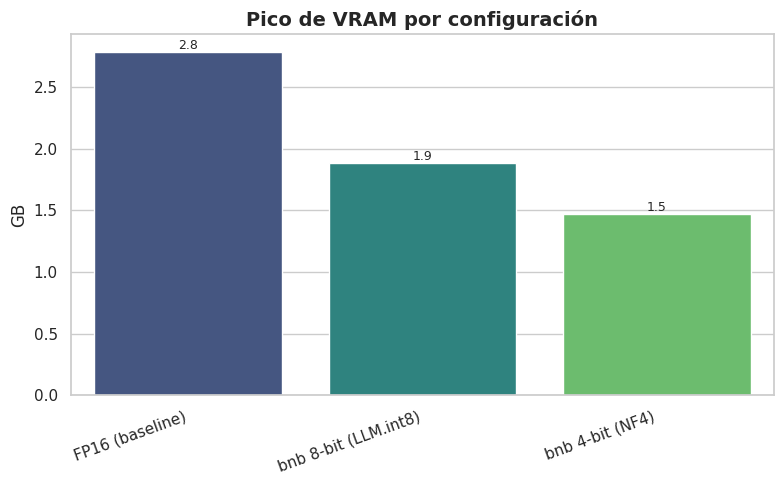

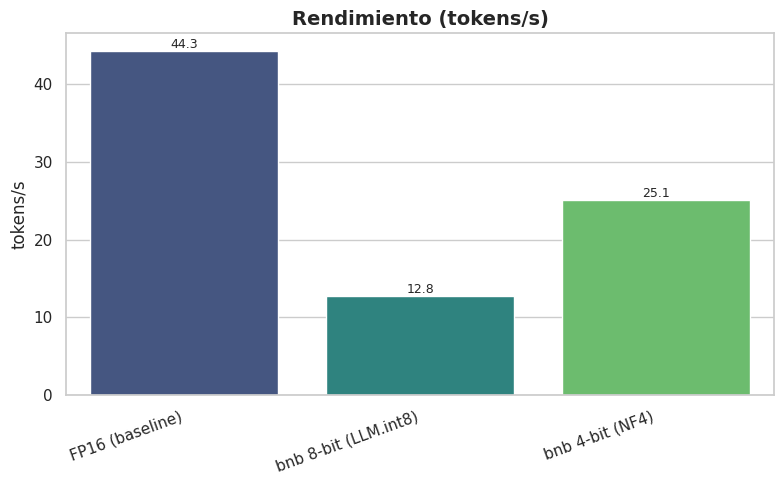

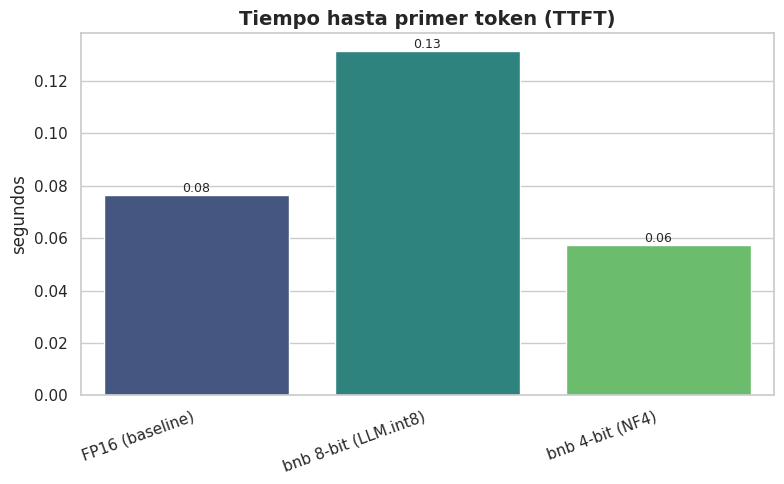

In [28]:

# ================================
# 8. Visualización de resultados 📈
# ================================
def plot_metric(df, y, title, ylabel, fmt="{:.1f}"):
    ax = sns.barplot(data=df, x="config", y=y, hue="config", palette="viridis", legend=False)
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    for container in ax.containers:
        ax.bar_label(container, fmt=fmt, label_type="edge", fontsize=9)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

plot_metric(df, "peak_VRAM_GB", "Pico de VRAM por configuración", "GB")
plot_metric(df, "tok/s", "Rendimiento (tokens/s)", "tokens/s")
plot_metric(df, "TTFT (s)", "Tiempo hasta primer token (TTFT)", "segundos", fmt="{:.2f}")

### Conclusión


1. FP16 → Ideal para máxima velocidad y throughput, pero con mayor costo de memoria.

2. 8-bit (LLM.int8) → Ahorra memoria, pero demasiado lento para ser práctico en producción de inferencia.

3. 4-bit (NF4) → Opción intermedia óptima: gran ahorro de VRAM (≈47%), con penalización razonable de rendimiento. Incluso logra un TTFT mejor que FP16, lo que puede ser útil en escenarios de baja latencia inicial.


#### Entonces .....
En teoría menos bits = más compresión/agresividad = menor precisión y más velocidad. Entonces uno pensaría que 8-bit debería ser más rápido y estable que 4-bit. Pero lo que estás viendo es real y se debe a varios factores técnicos:

- La implementación de 4-bit en bitsandbytes usa kernels especializados que están más optimizados para inferencia en GPUs modernas (Ampere / Ada).
- NF4 no es solo “4 bits truncados”, sino un esquema optimizado que aprende distribuciones gaussianas de los pesos y las representa mejor que simple int8.
- Esto hace que, a pesar de ser más agresivo, logre menos pérdida de precisión y mejor densidad de cómputo en GPU.





### Comparativa de cuantización de modelos LLM

| Configuración        | Ventajas principales                                          | Desventajas / Limitaciones                                    | Observaciones |
|---------------------|---------------------------------------------------------------|---------------------------------------------------------------|---------------|
| **FP16 (baseline)**  | - Máxima velocidad de generación<br>- Alto throughput (tokens/s)<br>- Precisión completa | - Mayor consumo de VRAM (~2.8 GB en el ejemplo)              | Ideal para GPU con suficiente memoria y cuando la velocidad es crítica |
| **bnb 8-bit (LLM.int8)** | - Ahorro de memoria (~32%)<br>- Mantiene cierta precisión estable | - Muy lento en inferencia (−71% tok/s)<br>- TTFT más alto   | Diseñado para estabilidad y compatibilidad; overhead de outliers reduce velocidad |
| **bnb 4-bit (NF4)**  | - Gran ahorro de VRAM (~47%)<br>- TTFT incluso más rápido que FP16<br>- Mejor densidad de cómputo en GPU | - Velocidad reducida frente a FP16 (−43% tok/s)<br>- Puede perder algo de precisión | Kernel optimizado para GPUs modernas; sorprendentemente eficiente a pesar de ser más agresivo |


### TODO / siguientes pasos

1. Probar con modelos más grandes (ej. 7B, 13B) para ver cómo escala el ahorro de VRAM.

2. Incluir cuantización dinámica y QLoRA para entrenamiento eficiente.

3. Medir también tiempo hasta primer token (TTFT), ya que es importante para aplicaciones interactivas.

4. Comparar diferentes técnicas de cuantización (e.g. GPTQ, AWQ) y no solo bitsandbytes.

5. Explorar el impacto en la calidad de las respuestas (no solo métricas de rendimiento).